In [1]:
import numpy as np
import uproot as up
import utils
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, sqrtm
from scipy.optimize import minimize
from scipy.stats import norm, rv_histogram

In [2]:
# Results from NUISANCE
F = up.open("0pi/nuisance.root")
unfolded_h = F["T2K_NuMu_CC0pi_C_XSec_2DPcos_data"].to_numpy()
bins = unfolded_h[1]
unfolded_h = (unfolded_h[0] * 1e38, bins)

In [3]:
# MC (GENIEv3 G18_10a_02_11a)
MC_h = F["T2K_NuMu_CC0pi_C_XSec_2DPcos_MC"].to_numpy()
MC_h = (MC_h[0] * 1e38, bins)

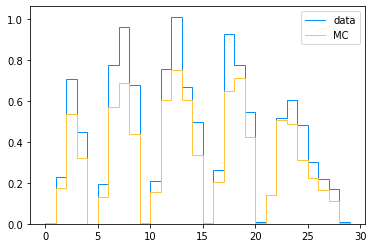

In [4]:
plt.stairs(*unfolded_h, label="data")
plt.stairs(*MC_h, label="MC")
plt.legend()

In [5]:
# Error bars
cov_unfolded = F["T2K_NuMu_CC0pi_C_XSec_2DPcos_COV"].to_numpy()[0]
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None] * np.sqrt(np.diag(cov_unfolded))[None, :]
)
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded[~np.isfinite(cor_unfolded)] = 0

(
    np.sqrt(np.max(np.diag(cov_unfolded))),
    np.max(cor_unfolded),
    np.min(cor_unfolded),
    np.min(cov_unfolded),
)

(0.17549715392632312,
 1.0000000000000002,
 0.1087878809191858,
 2.8280054473142367e-08)

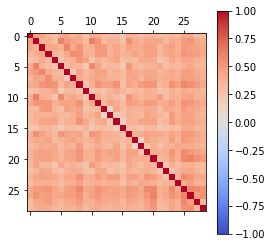

In [6]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

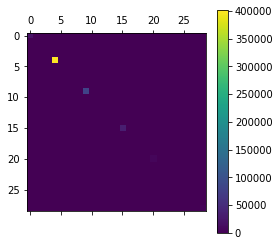

In [7]:
# Regularisation
C = utils.Q1s(MC_h[0])
plt.matshow(C)
plt.colorbar()

In [8]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

tau_list = [0.0] + list(np.logspace(0, 2, 9 + 8))
A_list = [
    np.linalg.inv(cov_unfolded_inv + tau * C) @ cov_unfolded_inv for tau in tau_list
]
regularised_list = [A @ unfolded_h[0] for A in A_list]

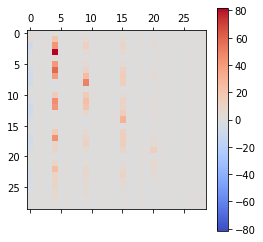

In [9]:
plt.matshow(A_list[-1], cmap="coolwarm", vmin=-np.max(A_list[-1]))
plt.colorbar()

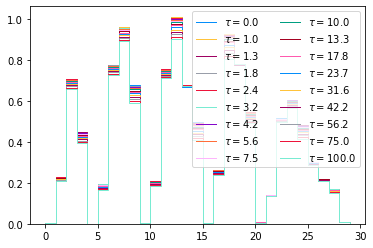

In [10]:
for x, tau in zip(regularised_list, tau_list):
    plt.stairs(x, bins, label=fr"$\tau = {tau:3.1f}$")
plt.legend(ncol=2)

In [11]:
# Metrics
jaggedness = [x.T @ C @ x for x in regularised_list]
bias = [
    (x - unfolded_h[0]).T @ cov_unfolded_inv @ (x - unfolded_h[0])
    for x in regularised_list
]

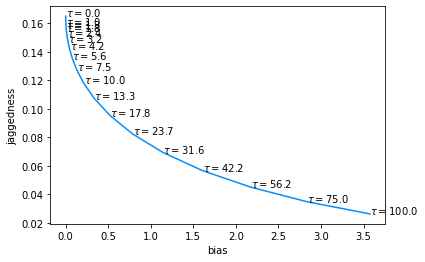

In [12]:
plt.plot(bias, jaggedness)
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(bias, jaggedness, tau_list):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))

In [13]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov_unfolded @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(cov) ** (-0.5)) @ cov @ np.diag(np.diag(cov) ** (-0.5))
    for cov in cov_list
]
cov_det_list = [np.linalg.det(cov) for cov in cov_list]
cor_det_list = [np.linalg.det(cor) for cor in cor_list]

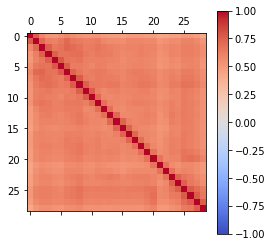

In [14]:
plt.matshow(cor_list[-1], cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [15]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
dist = []
diag_dist = []


def wasserstein(x, cov, base_x=unfolded_h[0], base_cov=cov_unfolded):
    U = cholesky(np.linalg.inv(base_cov))
    m = U @ base_x
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, cov in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, cov))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(cov))))

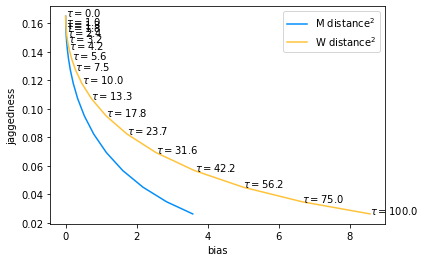

In [16]:
plt.plot(bias, jaggedness, label="M distance$^2$")
plt.plot(dist, jaggedness, label="W distance$^2$")
plt.legend()
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(dist, jaggedness, tau_list):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))

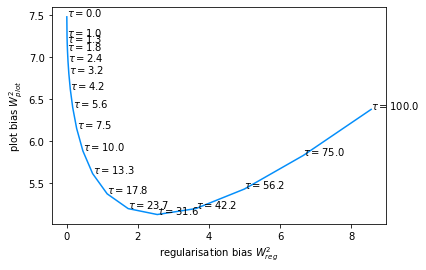

In [17]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $W^2_{reg}$")
plt.ylabel("plot bias $W^2_{plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y < best:
        best = y
        i_W = i

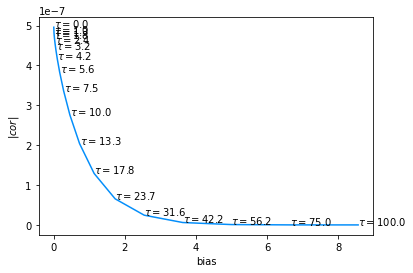

In [18]:
plt.plot(dist, cor_det_list)
plt.xlabel("bias")
plt.ylabel(r"$|cor|$")
i_D = 0
best = 0
for i, (x, y, tau) in enumerate(zip(dist, cor_det_list, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y > best:
        best = y
        i_D = i

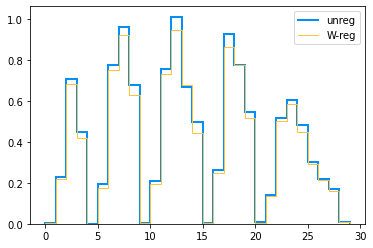

In [19]:
plt.stairs(*unfolded_h, label="unreg", linewidth=2)
plt.stairs(regularised_list[i_W], bins, label="W-reg")
plt.legend()

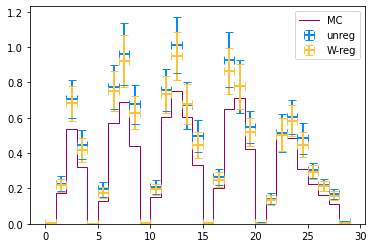

In [20]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="unreg", linewidth=2, linestyle="", capsize=4
)

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="W-reg", linewidth=2, linestyle="", capsize=4
)

plt.stairs(*MC_h, label="MC")

plt.legend()

In [21]:
# Fit normalisation
def minfun(p):
    mc = MC_h[0] * p
    diff = unfolded_h[0] - mc
    return diff.T @ cov_unfolded_inv @ diff


ret = minimize(minfun, x0=1.0)
print(ret)
MC_fit = MC_h[0] * ret.x[0]

      fun: 18.62648311639319
 hess_inv: array([[1]])
      jac: array([-2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([1.00391265])


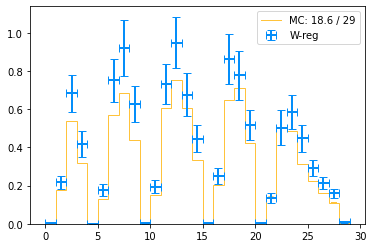

In [22]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="W-reg", linewidth=2, linestyle="", capsize=4
)

A = A_list[i_W]
reg_cov = cov_list[i_W]
reg_cov_inv = np.linalg.inv(reg_cov)

model = MC_h[0]
diff = y - A @ MC_h[0]
chi = diff.T @ reg_cov_inv @ diff
grad = utils.xsec_grad(model, unfolded_h[0], cov_unfolded_inv)

plt.stairs(model, bins, label=f"MC: {chi:.1f} / {len(grad)}")
for ax, ay, dy in zip(x, MC_h[0], grad):
    plt.arrow(
        ax,
        ay,
        0,
        dy,
        head_width=0.5,
        length_includes_head=True,
        head_length=np.abs(dy),
        color="C1",
    )

# plt.yscale("log")
plt.legend()

0.004395660444277909 7.8051262020257886


Text(0.5, 0, 'bin number')

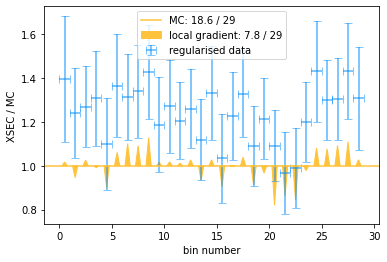

In [23]:
# data / MC
norm = MC_h[0]
ys = regularised_list[i_W] / norm
yerrs = np.sqrt(np.diag(cov_list[i_W])) / norm
plt.errorbar(
    x,
    ys,
    yerr=yerrs,
    xerr=xerr,
    label="regularised data",
    linewidth=2,
    linestyle="",
    capsize=4,
    alpha=0.5,
)

model = MC_h[0]
chi = utils.chi2(model, unfolded_h[0], cov_unfolded_inv)
grad = utils.scaled_grad(norm, model, unfolded_h[0], cov_unfolded_inv)
chi_grad = utils.chi2(model * (grad + 1.0), unfolded_h[0], cov_unfolded_inv)
print(np.sum(grad), chi_grad)
ys = model / norm
# plt.stairs(ys, bins, baseline=None, color="C1")
plt.axhline(1.0, color="C1", label=f"MC: {chi:.1f} / {len(model)}")
for ax, ay, dy in zip(x, ys, grad):
    ar = plt.arrow(
        ax,
        ay,
        0,
        dy,
        head_width=0.5,
        length_includes_head=True,
        head_length=np.abs(dy),
        color="C1",
    )
ar.set_label(f"local gradient: {chi_grad:.1f} / {len(model)}")

plt.legend()
plt.ylabel("XSEC / MC")
plt.xlabel("bin number")